## ExtraTrees (сверхслучайные деревья)

Основное отличие сверхслучайных деревьев от случайных лесов заключается в вычислении разбиения в узлах деревьев.

Как и в `Random Forest`, в `ExtraTrees` перед каждым разбиением дерева генерируется выборка из `min(d, max_features)` случайных признаков (`d` - количество признаков в датасете), но вместо поиска самих пороговых значений `t` для разбиения пороги генерируются случайным образом для каждого из выбранных признаков (по одному для каждого признака). 

По заданному критерию информативности мы выбираем лучший из этих случайно сгенерированных порогов в качестве разделяющего правила в узле. 

Такой случайный выбор порогов позволяет немного уменьшить дисперсию модели за счет несколько большего увеличения смещения. Подробнее об этом в [статье создалей `ExtraTrees`](https://orbi.uliege.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, \
      RandomForestClassifier, RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles, make_classification

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve

import seaborn as sns
sns.set(font_scale=1.5)

Сгенерируем датасет с помощью функции `make_classification` и обучим на нем `Random Forest` и `Extra Trees`:

In [21]:
X, y = make_classification(
    n_samples=500, n_features=2, n_classes=4, 
    n_redundant=0, n_clusters_per_class=1, random_state=42
)

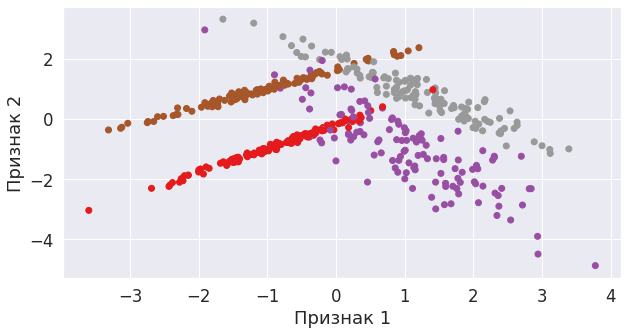

In [22]:
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2');

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf.fit(X_train, y_train)
accuracy_score(y_test, random_forest_clf.predict(X_test))

0.91

In [13]:
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_clf.fit(X_train, y_train)
accuracy_score(y_test, extra_trees_clf.predict(X_test))

0.92

## Эмбединги с помощью сверхслучайных лесов

Леса/деревья разной степени случайности обычно используется для задач обучения с учителем, но также есть возможность проводить обучение и без учителя, то есть переводить объекты из одного векторного пространства в другое.

Для изучения вопроса обучения без учителя с помощью лесов вспомним, что такое эмбединг:

Эмбединг --  это представление объекта (изображения, слова, аудиозаписи) в векторном пространстве так, чтобы сохранять локальное расстояние между объектами -- то есть близкие (в каком-то смысле) объекты имели похожие представления. Формально, [расширенный] эмбединг это отображение $h: \mathbb{R}^D \to \mathbb{R}^d$, причем **не** обязательно $d<D$.

С помощью класса `sklearn.ensemble.RandomTreesEmbedding` мы можем сделать трансформацию нашего датасета в многомерное разреженное его представление (Extended Embedding).

Алгоритм такой трансформации данных следующий: 
1. Cтроим сверхслучайные деревья на обучающей выборке без учителя: в качестве таргета берем случайные величины из равномерного распределения с критерием информативности `MSE`.
2. Делаем сквозное индексирование всех листьев во всех деревьях леса. Индексы листьев -- признаки в новом векторном пространстве. Размер полученного вектрного пространства $\leq \mbox{n_estimators} \cdot 2^{\mbox{max_depth}}$
3. Кодируем объекты (бинарное кодирование): если в $i$-ый лист попал объект, то на $i$-ую позицию в закодированном векторе мы поставим 1, а если не попал, то 0.


Контролировать количество признаков и также степень разреженности нашего нового векторного представления датасета мы можем увеличивая/уменьшая количество деревьев и их глубины. 

Сгенерируем нелинейный датасет и попробуем обучить на нем логистическую регрессию, а после преобразуем данные с помощью `RandomTreesEmbedding` и обучим логистическую регрессию на преобразованных данных

In [ ]:
X, y = make_circles(factor=0.5, random_state=42, noise=0.1)

plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='Set1')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2');

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Обучаем логистическую регрессию:

In [0]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_test, log_reg.predict(X_test))

0.3333333333333333

Видим, что качество получилось весьма посредственным: дело в том, что данные нелинейные

Попробуем для начала перевести исходные данные в другое векторное пространство, а уже потом обучить на этом логистическую регрессию:

In [0]:
random_trees_emb = RandomTreesEmbedding(n_estimators=10, random_state=42, max_depth=3)
X_train_emb = random_trees_emb.fit_transform(X_train)
X_test_emb = random_trees_emb.transform(X_test)

In [0]:
log_reg = LogisticRegression()

In [0]:
log_reg.fit(X_train_emb, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
accuracy_score(y_test, log_reg.predict(X_test_emb))

0.9333333333333333

Полученное качество оказалось заметно лучше в силу того, что в новом признаковом пространстве модель нашла некоторую линейность